## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Imports

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

%matplotlib inline
#%matplotlib qt

## Global variables

In [2]:
path_camera_calibration = './camera_cal/'
path_test_images = './test_images/'

## Calibration

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
obj_p = np.zeros((6*9, 3), np.float32)
obj_p[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
obj_points = [] # 3d points in real world space
img_points = [] # 2d points in image plane.

# Make a list of calibration images
images_list = glob.glob(path_camera_calibration + 'calibration*.jpg')
images = []

# Step through the list and search for chessboard corners
for fname in images_list:
    # Read each image
    img = cv2.imread(fname)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If corners are found, add object points, image points and image to images array
    if ret == True:
        obj_points.append(obj_p)
        img_points.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        images.append(img)
        
        # Visualze drawings
        #cv2.imshow('img', img)
        #cv2.waitKey(500)
        
dist_pickle = {}
dist_pickle['obj_points'] = obj_points
dist_pickle['img_points'] = img_points
pickle.dump(dist_pickle, open(path_camera_calibration + 'wide_dist_pickle.p', 'wb'))

### Destroy all cv2 windows

In [4]:
#cv2.destroyAllWindows()

## Correction for Distortion

In [5]:
# Test undistortion on an image
for img in images:
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_size, None, None)

    # Undistort the image
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    #cv2.imwrite(path_camera_calibration + 'calibration_wide/test_undist.jpg',dst)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    #dist_pickle = {}
    #dist_pickle['mtx'] = mtx
    #dist_pickle['dist'] = dist
    #pickle.dump(dist_pickle, open(path_camera_calibration + 'wide_dist_pickle.p', 'wb'))
    #dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

    # Visualize undistortion
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    #ax1.imshow(img)
    #ax1.set_title('Original Image', fontsize=30)
    #ax2.imshow(dst)
    #ax2.set_title('Undistorted Image', fontsize=30)


### Test calibration

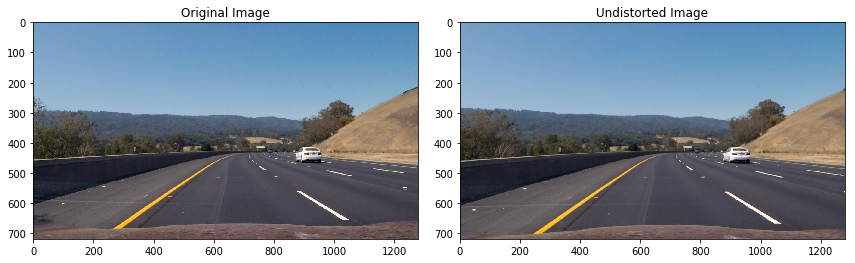

In [7]:
# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load(open(path_camera_calibration + 'wide_dist_pickle.p', 'rb'))
obj_points = dist_pickle['obj_points']
img_points = dist_pickle['img_points']

# Read in an image
img = mpimg.imread(path_test_images + 'test3.jpg')

# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, obj_points, img_points):
    # Use cv2.calibrateCamera() and cv2.undistort()
    img_size = (img.shape[1], img.shape[0])
    retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_size, None, None)
    undist = cv2.undistort(img, cameraMatrix, distCoeffs, None, cameraMatrix)
    return undist

undistorted = cal_undistort(img, obj_points, img_points)

# Show difference
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=12)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=12)